In [ ]:
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D, LSTM, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_true = pd.read_csv("/content/drive/MyDrive/Fake News Dataset/True.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/Fake News Dataset/Fake.csv")

df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_true['label'] = 0
df_fake['label'] = 1

In [ ]:
df = pd.concat([df_true, df_fake])
random_permutation = np.random.permutation(len(df))
df = df.iloc[random_permutation]
print(df.columns)
df.head()

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


,title,text,subject,date,label
17917,WOW! FANS BREAK NFL JERSEY SALES RECORD For 3-...,Pittsburgh s head coach Mike Tomlin showed his...,left-news,"Sep 25, 2017",1
19816,"Tillerson, Russia's Lavrov discuss Syria, Ukra...",NEW YORK (Reuters) - Russian Foreign Minister ...,worldnews,"September 18, 2017",0
8933,Puerto Rico debt bill gains backers in U.S. Se...,WASHINGTON (Reuters) - The Obama administratio...,politicsNews,"June 28, 2016",0
7049,Vice President-elect Pence says 'new hope dawn...,WASHINGTON (Reuters) - U.S. Vice President-ele...,politicsNews,"November 26, 2016",0
6767,Casts Of Broadway’s ‘Hamilton’ And ‘Color Pur...,The world is reeling from the shocking news of...,News,"April 22, 2016",1


In [ ]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [ ]:
df['feature'] = df['title']+' '+df['text']+' '+df['subject']

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df['feature'] = df['feature'].str.lower()
df.head()

import string
def remove_punctuations(text):
    punctuations = set(string.punctuation)
    text = str(text)
    # return text.translate(str.maketrans('', '', punctuations))
    return " ".join([word for word in text.split() if word not in punctuations])

df['feature'] = df['feature'].apply(lambda x: remove_punctuations(x))

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

df['feature'] = df['feature'].apply(lambda x: remove_stopwords(x))

import re
def remove_spl_chars(text):
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

df['feature'] = df['feature'].apply(lambda x: remove_spl_chars(x))

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')
def stem(text):
    stemmed_sentence = " ".join(stemmer.stem(word) for word in text.split())
    return stemmed_sentence

df['feature'] = df['feature'].apply(lambda x: stem(x))

def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

df['feature'] = df['feature'].apply(lambda x: remove_url(x))

In [ ]:
df.dropna(subset=['feature'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
texts = []
labels = []
for i in range(44894):
    texts.append(df['text'][i])
    labels.append(df['label'][i])

print(len(texts))
len(labels)

44894


44894

In [ ]:
max_words = 100000
max_seq_length = 4000
# the percentage of train test split to be applied
validation_split = 0.2
# the dimension of vectors to be used
embedding_dim = 100
# filter sizes of the different conv layers
filter_sizes = [3,4,5]
num_filters = 512
# dropout probability
drop = 0.5
batch_size = 30
epochs = 2

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
len(word_index)

138015

In [ ]:
data = pad_sequences(sequences, maxlen=max_seq_length)
labels = np.asarray(labels)
print("Shape of data tensor: ", data.shape)
print("Shape of label tensor: ", labels.shape)

Shape of data tensor:  (44894, 4000)
Shape of label tensor:  (44894,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(validation_split * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
max_features = 200000
maxlen_sentence = 200
maxlen_word = 20
batch_size = 32
embedding_dims = 100

In [ ]:
x_train.shape

(35916, 4000)

In [ ]:
len(x_train)

35916

In [ ]:
X_train = x_train.reshape((len(x_train), maxlen_sentence, maxlen_word))
X_test = x_val.reshape((len(x_val), maxlen_sentence, maxlen_word))
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (35916, 200, 20)
x_test shape: (8978, 200, 20)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
!ls
!pwd

--2024-01-10 13:43:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-10 13:43:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-10 13:43:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embeddings_idx = {}
f = open("./glove.6B.100d.txt", encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_idx[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_idx.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

##Attention

In [ ]:
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.layers import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize

In [ ]:
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.layers import Layer


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2
            hidden = LSTM(64, return_sequences=True)(words)
            sentence = Attention()(hidden)
            # next add a Dense layer (for classification/regression) or whatever...
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(name='{}_W'.format(self.name),
                                 shape=(input_shape[-1],),
                                 initializer=self.init,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(name='{}_b'.format(self.name),
                                     shape=(input_shape[1],),
                                     initializer='zero',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

In [ ]:
from keras import Input, Model
from keras.layers import Embedding, Dense, Bidirectional, TimeDistributed
# from keras.layers import CuDNNGRU
from keras.layers import GRU
import keras

class HCAN(Model):
    def __init__(self,
                 maxlen_sentence,
                 maxlen_word,
                 max_features,
                 embedding_dims,
                 class_num=1,
                 last_activation='sigmoid'):
        super(HCAN, self).__init__()
        self.maxlen_sentence = maxlen_sentence
        self.maxlen_word = maxlen_word
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation
        # Word part
        input_word = Input(shape=(self.maxlen_word,))
        x_word = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen_word)(input_word)
        x_word = keras.layers.Convolution1D(100, 10, activation="relu", padding = 'same')(x_word)


        x_word = Bidirectional(GRU(128, return_sequences=True))(x_word)  # LSTM or GRU
        x_word = Attention(self.maxlen_word)(x_word)
        model_word = Model(input_word, x_word)
        # Sentence part
        self.word_encoder_att = TimeDistributed(model_word)
        self.sentence_encoder = Bidirectional(GRU(128, return_sequences=True))  # LSTM or GRU
        self.sentence_att = Attention(self.maxlen_sentence)
        # Output part
        self.classifier = Dense(self.class_num, activation=self.last_activation)

    def call(self, inputs):
            if len(inputs.get_shape()) != 3:
                raise ValueError('The rank of inputs of HAN must be 3, but now is %d' % len(inputs.get_shape()))
            if inputs.get_shape()[1] != self.maxlen_sentence:
                raise ValueError('The maxlen_sentence of inputs of HAN must be %d, but now is %d' % (self.maxlen_sentence, inputs.get_shape()[1]))
            if inputs.get_shape()[2] != self.maxlen_word:
                raise ValueError('The maxlen_word of inputs of HAN must be %d, but now is %d' % (self.maxlen_word, inputs.get_shape()[2]))
            x_sentence = self.word_encoder_att(inputs)
            x_sentence = self.sentence_encoder(x_sentence)
            x_sentence = self.sentence_att(x_sentence)
            output = self.classifier(x_sentence)
            return output

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
epochs = 3
print('Build model...')
model = HCAN(maxlen_sentence, maxlen_word, max_features, embedding_dims)
with tf.device('/device:GPU:0'):
  model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])


print('Train...')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=epochs,
          callbacks=[early_stopping],
          validation_split=0.2)

print('Test...')
result = model.predict(X_test)


Build model...
Train...
Epoch 1/3
225/225 [==============================] - 129s 538ms/step - loss: 0.2192 - accuracy: 0.8936 - val_loss: 0.0566 - val_accuracy: 0.9832
Epoch 2/3
225/225 [==============================] - 120s 534ms/step - loss: 0.0241 - accuracy: 0.9930 - val_loss: 0.0179 - val_accuracy: 0.9965
Epoch 3/3
225/225 [==============================] - 120s 532ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0240 - val_accuracy: 0.9960
Test...
281/281 [==============================] - 14s 42ms/step


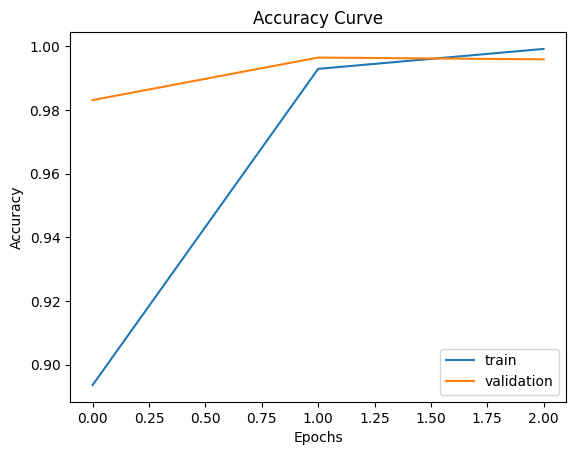

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

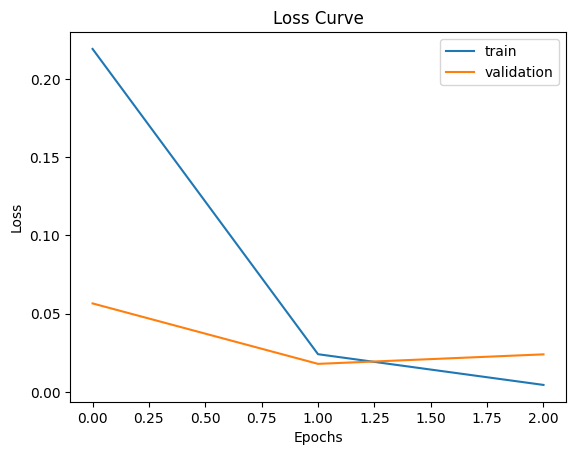

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
result

array([[9.9998379e-01],
       [1.4089153e-03],
       [3.1885048e-04],
       ...,
       [5.2311411e-04],
       [9.9993348e-01],
       [7.8941899e-04]], dtype=float32)

In [ ]:
pred = []
for p in result:
  if p[0] > 0.5:
    pred.append(1)
  else:
    pred.append(0)

In [ ]:
from sklearn.metrics import classification_report
cl = classification_report(pred, y_val)

In [ ]:
print(cl)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4236
           1       1.00      0.99      1.00      4742

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978

